In [1]:
# import libraries
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as st
import seaborn as sns 
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.offline as py
from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv("/content/drive/MyDrive/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [5]:
df.shape

(4857377, 8)

In [6]:
# Here I start cleaning the data. Firstly, converting Timestamp to datetime64
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
# sets the index as the date
df.index = df.Timestamp
# Resamples the data to the average daily value of each column. Removes excessive frequency
df = df.resample('D').mean()
# drops any missing values that are present
df = df.dropna()
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


In [7]:
df.shape
# Now we have 3,376 rows instead of 4 million - with no missing values and accurate datetime information

(3376, 7)

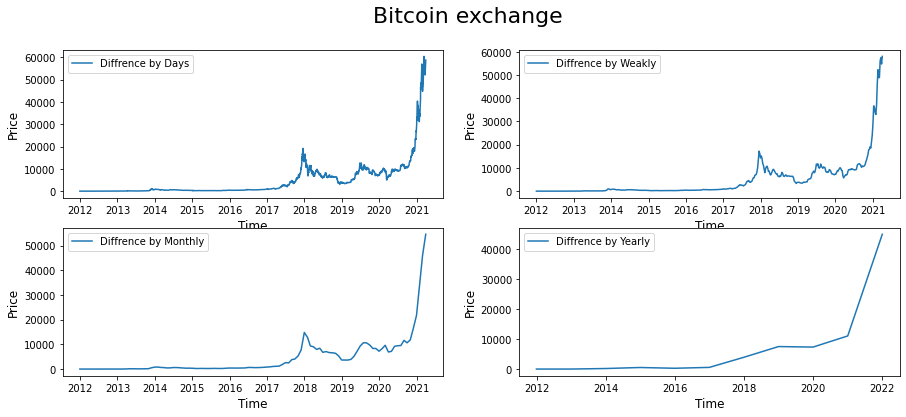

In [8]:
data=df.resample('D').mean()
data_week=df.resample('W').mean()
data_month=df.resample('M').mean()
data_year=df.resample('A-DEC').mean()
fig = plt.figure(figsize=[15, 6])
plt.suptitle('Bitcoin exchange', fontsize=22)
plt.subplot(221)
plt.plot(data.Weighted_Price, '-',label='Daily')
plt.legend(["Diffrence by Days"],loc="upper left")
plt.xlabel('Time',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.subplot(222)
plt.plot(data_week.Weighted_Price, '-',label='Weakly')
plt.legend(["Diffrence by Weakly"],loc="upper left")
plt.xlabel('Time',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.subplot(223)
plt.plot(data_month.Weighted_Price, '-',label='Monthly')
plt.legend(["Diffrence by Monthly"],loc="upper left")
plt.xlabel('Time',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.subplot(224)
plt.plot(data_year.Weighted_Price, '-',label='Yearly')
plt.legend(["Diffrence by Yearly"],loc="upper left")
plt.xlabel('Time',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.show()

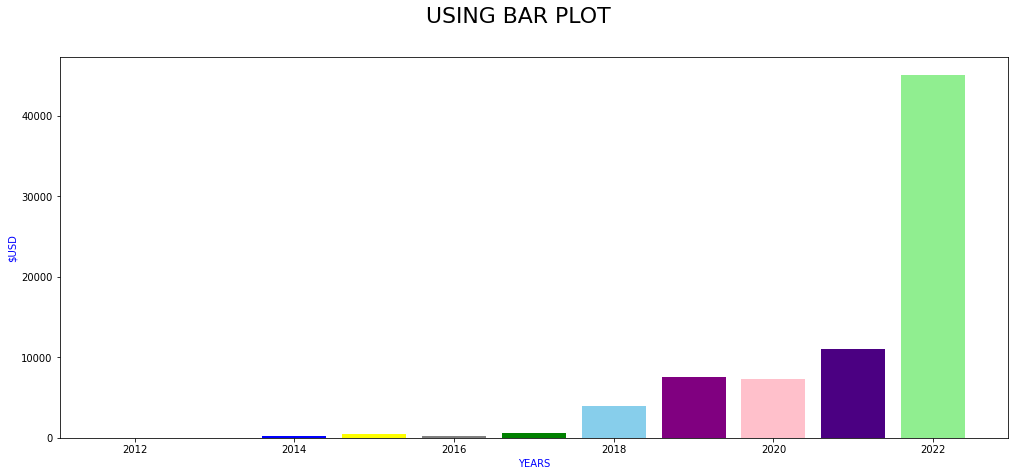

In [9]:
fig = plt.figure(figsize=[17,7])
plt.suptitle('USING BAR PLOT', fontsize=22)
years=[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
plt.bar(years,data_year.Weighted_Price,color=["red","orange","blue","yellow","gray","green","skyblue","purple","pink","indigo","lightgreen"])
plt.xlabel("YEARS",color="blue")
plt.ylabel("$USD",color="blue")
plt.show()

Dickey Fuller test value of P is = 0.998863
The time series is not stationary


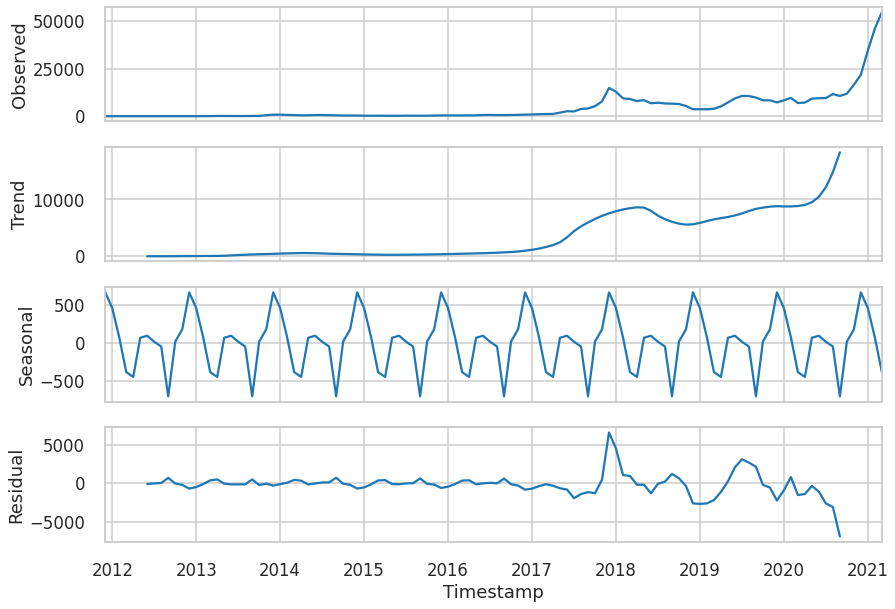

In [10]:
plt.style.use('seaborn-poster')
sns.set_style('whitegrid')
sns.set_context('talk')
st.tsa.seasonal_decompose(data_month.Weighted_Price).plot()
result=st.tsa.stattools.adfuller(data_month.Weighted_Price)[1]
print("Dickey Fuller test value of P is = %f"%result)
if result>0.05:
    print("The time series is not stationary")
else:
    print("The time series is stationary")
plt.show()

In [11]:
data_month['prices_diff'] = data_month.Weighted_Price - data_month.Weighted_Price.shift(12)
result=st.tsa.stattools.adfuller(data_month.prices_diff[12:])[1]
print("Dickey Fuller test value of P is = %f"%result)
if result>0.05:
    print("The time series is not stationary")
else:
    print("The time series is stationary")

Dickey Fuller test value of P is = 0.993080
The time series is not stationary


In [12]:
data_month['prices_diff2'] = data_month.prices_diff - data_month.prices_diff.shift(1)  
result=st.tsa.stattools.adfuller(data_month.prices_diff2[13:])[1]
print("Dickey Fuller test value of P is = %f"%result)
if result>0.05:
    print("The time series is not stationary")
else:
    print("The time series is stationary")

Dickey Fuller test value of P is = 0.017699
The time series is stationary


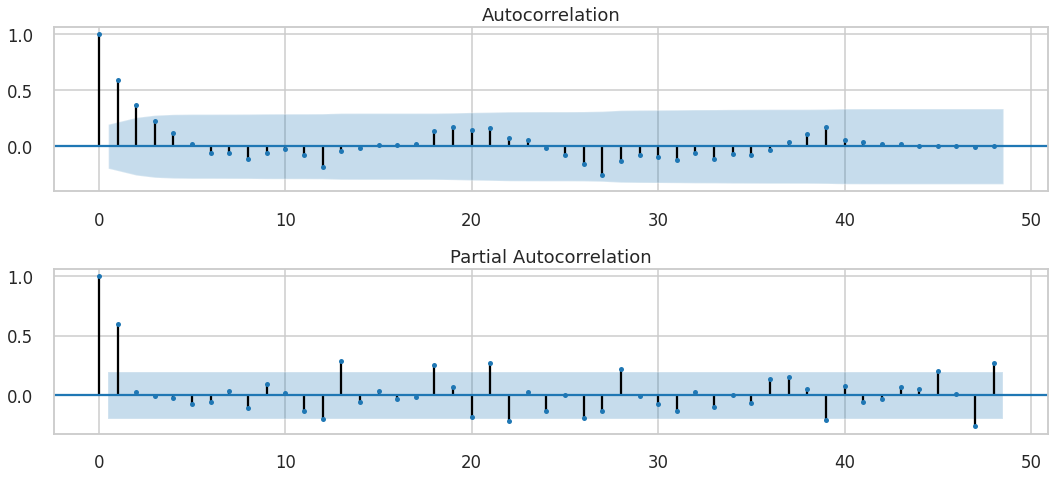

In [13]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
st.graphics.tsa.plot_acf(data_month.prices_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
st.graphics.tsa.plot_pacf(data_month.prices_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [14]:
# method to be used later
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [15]:
# Split the data as usual 70, 30
price = df.Weighted_Price
X = price.values
datesX = price.index
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
days_in_year = 365

In [16]:
print(len(train))

2363


In [17]:
print(len(test))

1013


In [18]:
# Next we will forecast with ARIMA using 5,1,0
plotDates = datesX[size:len(X)]
differenced = difference(train, days_in_year)
model = ARIMA(differenced, order=(5, 1, 0))
model_fit = model.fit()
start_index = len(differenced)
end_index = start_index + 1012
forecast = model_fit.predict(start=start_index, end=end_index)

history = [x for x in train]
day = 1
predicted_results = list()

# store predicted results 
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    history.append(inverted)
    predicted_results.append(inverted)
    day += 1

In [19]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1997
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -13277.613
Method:                       css-mle   S.D. of innovations            186.760
Date:                Tue, 24 May 2022   AIC                          26569.225
Time:                        19:04:08   BIC                          26608.421
Sample:                             1   HQIC                         26583.618
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8058      5.125      0.352      0.725      -8.240      11.851
ar.L1.D.y      0.1869      0.022      8.348      0.000       0.143       0.231
ar.L2.D.y      0.0419      0.023      1.844      0.0

In [20]:
rmse = np.sqrt(mean_squared_error(test, predicted_results))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 12137.312


In [21]:
import plotly.io as pio
pio.renderers.default = "colab"

In [22]:
trace1 = go.Scatter(
    x = np.arange(0, len(predicted_results), 1),
    y = predicted_results,
    mode = 'lines',
    name = 'Predicted labels',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(test), 1),
    y = test,
    mode = 'lines',
    name = 'True labels',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Day Number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

In [23]:
Timestamp = [dt(2021, 4, 30),dt(2021, 5, 30),dt(2021, 6, 30),dt(2021, 7, 30),dt(2021, 8, 30), dt(2022, 2, 28), dt(2022, 3, 31),dt(2022, 4, 19)]

trace1 = go.Scatter(x=Timestamp, y=test, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Timestamp, y=predicted_results, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')